## Machine learning Algorithm Trader

In this project, we will be using the OANDA v20 REST API  

<img style="float: left;" src="./images/api.png">




# Why forex over stocks?


![3advantage](./images/lvts.png)

### Liquidity  
The forex market is the largest and most liquid financial market. Daily activity often exceeds 4 trillion USD, with over 1.5 trillion of that conducted in the form of spot trading.


### Volatility  
Volatility boosts opportunity due to exchange rate fluctuations. Forex trading operates 24 hours a day, 5 days a week. The greatest liquidity occurs when operational hours in multiple time zones overlap.


### Tight Spreads  
Spreads in the forex market tend to be tighter (less), than the spreads applied to other, securities such as stocks. This makes OTC forex trading one of the most cost - effective means of investment trading.

In [1]:
#python packages required
#import sys

#!{sys.executable} -m pip install  v20  #OANDA V20 API
#!{sys.executable} -m pip install  ujson
#!{sys.executable} -m pip install  PyYAML
#!{sys.executable} -m pip install  --index-url https://test.pypi.org/simple/ tpqoa
#!{sys.executable} -m pip instal tensorflow
#!{sys.executable} -m pip install  keras
#!{sys.executable} -m pip install  scikeras
#!{sys.executable} -m pip install  h5py
#!{sys.executable} -m pip install  eli5
#!{sys.executable} -m pip install  pmdarima
# !{sys.executable} -m pip install pandas_ta
#!{sys.executable} -m pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import itertools
import random
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle as pkl
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from statsmodels.tsa.statespace.sarimax import SARIMAX


plt.style.use("seaborn")

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

1st we need to create an oanda.cfg file tha should look something like this.  
Fill up the details per your oanda account.

![3advantage](./images/config.png)

In [3]:
#sensitive ID and password have been gitignored you will need to create your own config file 

api = tpqoa.tpqoa("oanda-dnn.cfg")

In [4]:
api.get_account_summary()

{'id': '101-003-23224294-008',
 'alias': 'API TRADER day 3',
 'currency': 'USD',
 'balance': '100000.0',
 'createdByUserID': 23224294,
 'createdTime': '2022-10-20T05:07:33.880369842Z',
 'guaranteedStopLossOrderMode': 'ALLOWED',
 'pl': '0.0',
 'resettablePL': '0.0',
 'resettablePLTime': '0',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.1',
 'openTradeCount': 1,
 'openPositionCount': 1,
 'pendingOrderCount': 0,
 'hedgingEnabled': False,
 'unrealizedPL': '17.0',
 'NAV': '100017.0',
 'marginUsed': '9782.0',
 'marginAvailable': '90235.0',
 'positionValue': '97820.0',
 'marginCloseoutUnrealizedPL': '21.0',
 'marginCloseoutNAV': '100021.0',
 'marginCloseoutMarginUsed': '9782.0',
 'marginCloseoutPercent': '0.0489',
 'marginCloseoutPositionValue': '97820.0',
 'withdrawalLimit': '90235.0',
 'marginCallMarginUsed': '9782.0',
 'marginCallPercent': '0.0978',
 'lastTransactionID': '5'}

In [5]:
#ensure the accunt type is the OANDA demo account
api.account_type

'practice'

In [6]:
api.account_id

'101-003-23224294-008'

In [7]:
api.get_instruments()

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('Australia 200', 'AU200_AUD'),
 ('Bitcoin', 'BTC_USD'),
 ('Bitcoin Cash', 'BCH_USD'),
 ('Brent Crude Oil', 'BCO_USD'),
 ('Bund', 'DE10YB_EUR'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/HKD', 'CAD_HKD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('CAD/SGD', 'CAD_SGD'),
 ('CHF/HKD', 'CHF_HKD'),
 ('CHF/JPY', 'CHF_JPY'),
 ('CHF/ZAR', 'CHF_ZAR'),
 ('China A50', 'CN50_USD'),
 ('China H Shares', 'CHINAH_HKD'),
 ('Copper', 'XCU_USD'),
 ('Corn', 'CORN_USD'),
 ('EUR/AUD', 'EUR_AUD'),
 ('EUR/CAD', 'EUR_CAD'),
 ('EUR/CHF', 'EUR_CHF'),
 ('EUR/CZK', 'EUR_CZK'),
 ('EUR/DKK', 'EUR_DKK'),
 ('EUR/GBP', 'EUR_GBP'),
 ('EUR/HKD', 'EUR_HKD'),
 ('EUR/HUF', 'EUR_HUF'),
 ('EUR/JPY', 'EUR_JPY'),
 ('EUR/NOK', 'EUR_NOK'),
 ('EUR/NZD', 'EUR_NZD'),
 ('EUR/PLN', 'EUR_PLN'),
 ('EUR/SEK', 'EUR_SEK'),
 ('EUR/SGD', 'EUR_SGD'),
 ('EUR/TRY', 'EUR_TRY'),
 ('EUR/USD', 'EUR_U

In [8]:
instr = api.get_instruments()
len(instr)

128

There is a total of 12 instruments

## Getting Historical Data


In [9]:
#lets see how to use .get_history 
help(api.get_history)

Help on method get_history in module tpqoa.tpqoa.tpqoa:

get_history(instrument, start, end, granularity, price, localize=True) method of tpqoa.tpqoa.tpqoa.tpqoa instance
    Retrieves historical data for instrument.
    
    Parameters
    instrument: string
        valid instrument name
    start, end: datetime, str
        Python datetime or string objects for start and end
    granularity: string
        a string like 'S5', 'M1' or 'D'
    price: string
        one of 'A' (ask), 'B' (bid) or 'M' (middle)
    
    Returns
    data: pd.DataFrame
        pandas DataFrame object with data



In [10]:
df = api.get_history("EUR_USD", "2020-09-01", "2022-08-31", "M5", "M")
df.to_pickle("datasets/eur_usd.pkl")

In [11]:
df

,o,h,l,c,volume,complete
time,,,,,,
2020-09-01 00:00:00,1.19370,1.19439,1.19370,1.19436,341,True
2020-09-01 00:05:00,1.19434,1.19474,1.19422,1.19451,286,True
2020-09-01 00:10:00,1.19453,1.19476,1.19443,1.19472,212,True
2020-09-01 00:15:00,1.19474,1.19482,1.19458,1.19468,190,True
2020-09-01 00:20:00,1.19470,1.19482,1.19428,1.19448,188,True
...,...,...,...,...,...,...
2022-08-30 23:35:00,1.00230,1.00232,1.00213,1.00218,81,True
2022-08-30 23:40:00,1.00218,1.00247,1.00218,1.00244,97,True
2022-08-30 23:45:00,1.00242,1.00247,1.00236,1.00244,102,True


The data pulled has 7 columns,  
time, volume, complete, o, h, l, c,  
Lets rename them to make it easier to digest.


In [12]:

df = df.rename(columns={'o': 'open', 'h': 'high', 'l':'low', 'c': 'close'})


In [13]:
df.head()

,open,high,low,close,volume,complete
time,,,,,,
2020-09-01 00:00:00,1.19370,1.19439,1.19370,1.19436,341,True
2020-09-01 00:05:00,1.19434,1.19474,1.19422,1.19451,286,True
2020-09-01 00:10:00,1.19453,1.19476,1.19443,1.19472,212,True
2020-09-01 00:15:00,1.19474,1.19482,1.19458,1.19468,190,True
2020-09-01 00:20:00,1.19470,1.19482,1.19428,1.19448,188,True


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148874 entries, 2020-09-01 00:00:00 to 2022-08-30 23:55:00
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   open      148874 non-null  float64
 1   high      148874 non-null  float64
 2   low       148874 non-null  float64
 3   close     148874 non-null  float64
 4   volume    148874 non-null  int64  
 5   complete  148874 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 7.0 MB


In [15]:
#saving dataset to pkl
df.to_pickle('datasets/eur_usd.pkl')

In [16]:
plt.style.use("seaborn")

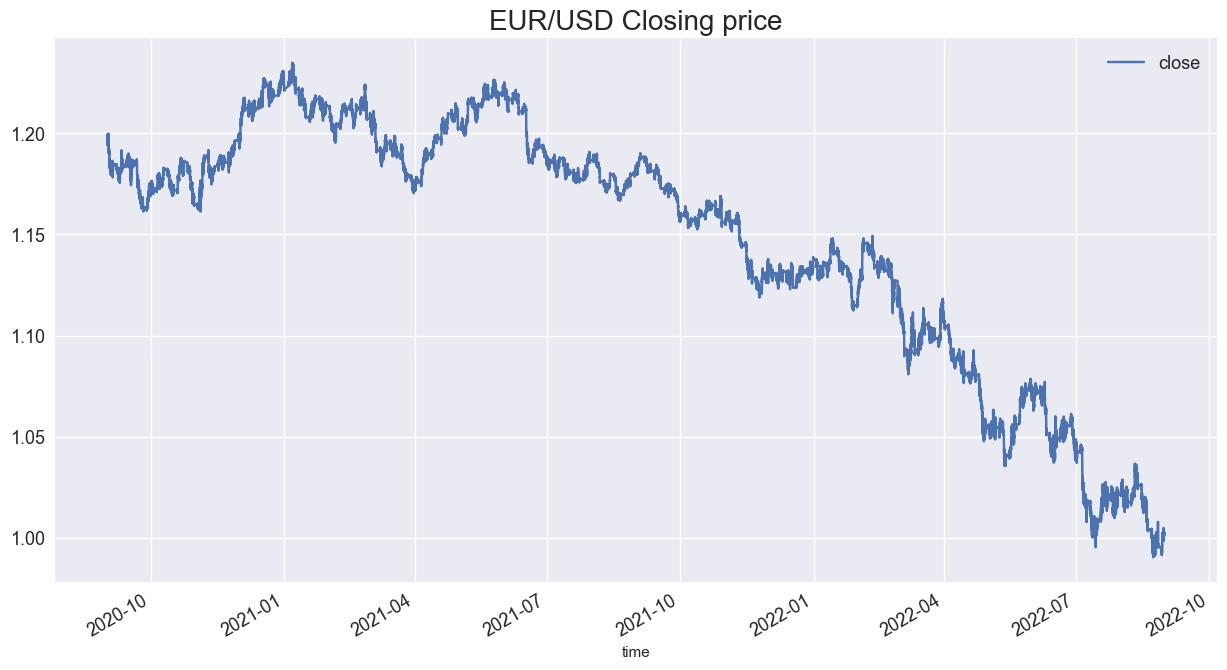

In [17]:
df.plot(y = "close", figsize = (15, 8 ), fontsize = 13)
plt.legend(fontsize = 13)
plt.title("EUR/USD Closing price", fontsize = 20)
plt.show();

In [18]:
#for the purpose of this project, we will be looking at only the closing price
df = df.close.to_frame()
df.head()

,close
time,
2020-09-01 00:00:00,1.19436
2020-09-01 00:05:00,1.19451
2020-09-01 00:10:00,1.19472
2020-09-01 00:15:00,1.19468
2020-09-01 00:20:00,1.19448


In [19]:
#creating a column for the log returns for the 5min interval
df["returns"] = np.log(df["close"].div(df["close"].shift(1)))

In [20]:
df.dropna(inplace=True)
df.head()

,close,returns
time,,
2020-09-01 00:00:00,1.19436,NaN
2020-09-01 00:05:00,1.19451,0.000126
2020-09-01 00:10:00,1.19472,0.000176
2020-09-01 00:15:00,1.19468,-0.000033
2020-09-01 00:20:00,1.19448,-0.000167


# Defining our Target variable

In [21]:
df["dir"] = np.where(df["returns"] > 0, 1, 0) # this indicates of returns are positive or negative

In [22]:
c0, c1 = np.bincount(df["dir"])

In [23]:
c0

76719

In [24]:
c1

72155

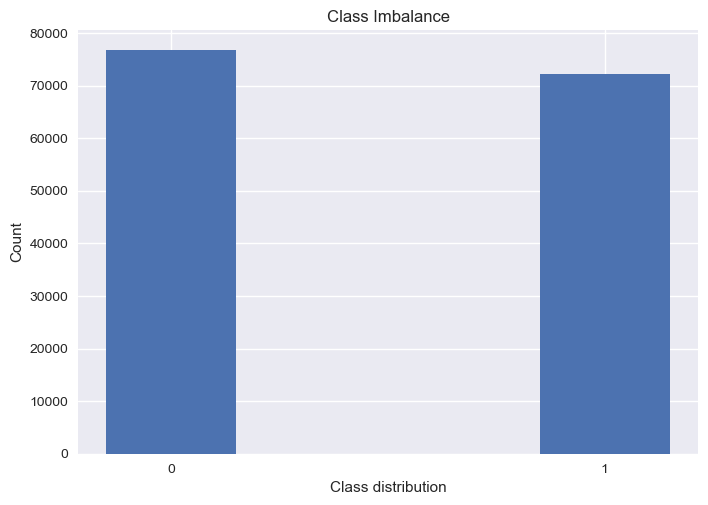

In [25]:
plt.bar(['0','1'], [c0,c1],
        width = 0.3)

plt.xlabel("Class distribution")
plt.ylabel("Count")
plt.title("Class Imbalance")
plt.show();

In [26]:
df

,close,returns,dir
time,,,
2020-09-01 00:00:00,1.19436,NaN,0
2020-09-01 00:05:00,1.19451,0.000126,1
2020-09-01 00:10:00,1.19472,0.000176,1
2020-09-01 00:15:00,1.19468,-0.000033,0
2020-09-01 00:20:00,1.19448,-0.000167,0
...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,0
2022-08-30 23:40:00,1.00244,0.000259,1
2022-08-30 23:45:00,1.00244,0.000000,0


# Feature Transformation

#### Just to clarify why I've done feature enginnering prior to train test split.  

In my view, none of these features are subject to data leakage as they are all based on rolling/past data. So, even if we had split before, features would have the same values.



In [27]:

window = 25 #based on a 50 period

df["sma"] = df['close'].rolling(window).mean() - df['close'].rolling(50).mean() #distance between SMA50 - SMA150
df["bol1"] = df['close'].rolling(window).mean() + df['close'].rolling(window).std()* 2
df["bol2"] = df['close'].rolling(window).mean() - df['close'].rolling(window).std()* 2
df["min"] = df['close'].rolling(window).min() / df['close'] - 1  #rolling min divided by current price -1
df["max"] = df['close'].rolling(window).max() / df['close'] - 1  #rolling max divided by current price -1
df["mom"] = df["returns"].rolling(3).mean()                      #rolling mean
df["vol"] = df["returns"].rolling(window).std()                  #rolling std deviation (volitility feature)
df.dropna(inplace = True)

In [28]:
# sma_plt = df[['close','sma']]
sma_plt = df[['close']].copy()
sma_plt["SMA_S_25"] = sma_plt.close.rolling(25).mean()
sma_plt["SMA_L_50"] = sma_plt.close.rolling(50).mean()


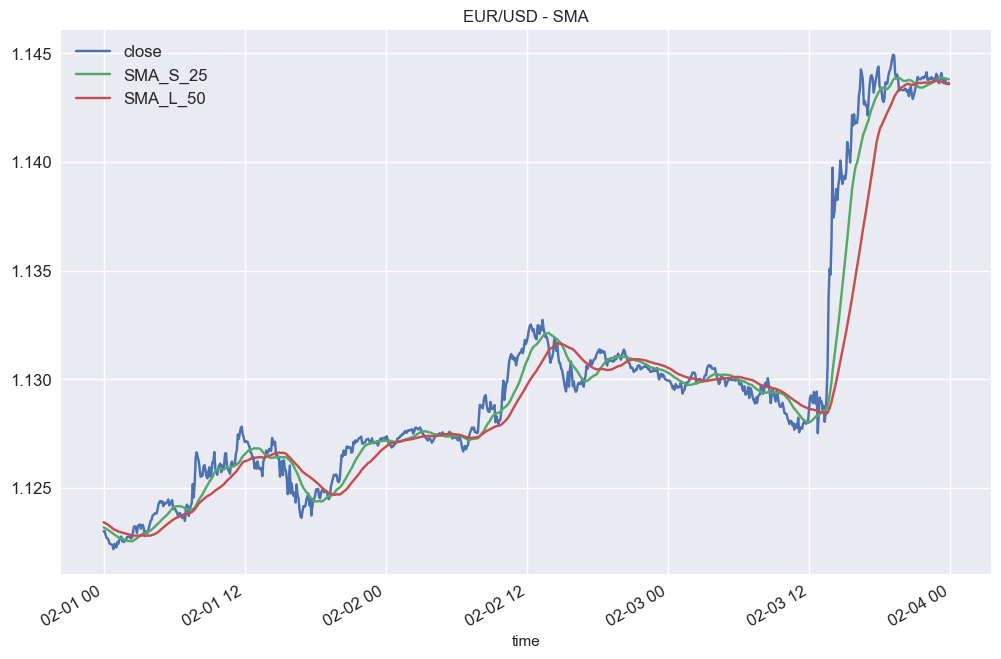

In [29]:
sma_plt.loc["2022-02-01" : "2022-02-3"].plot(figsize = (12, 8), title = "EUR/USD - SMA", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

In [30]:
# bol_plt = df[['close','vol']]
sma_plt["bol1"] = df[['bol1']].copy()
sma_plt["bol2"]= df[['bol2']].copy()

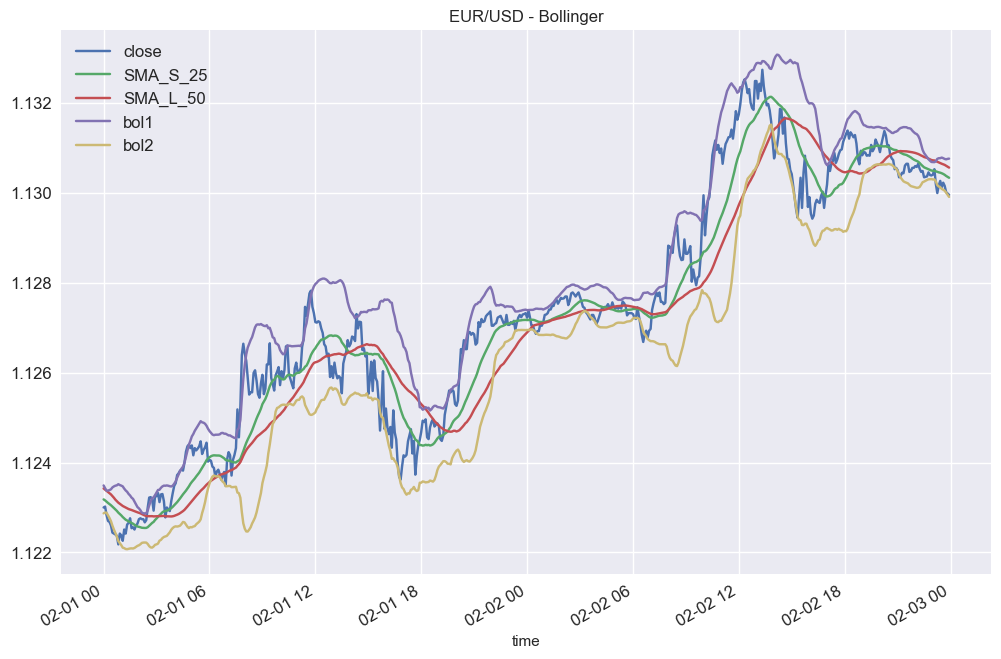

In [31]:
sma_plt.loc["2022-02-01" : "2022-02-02"].plot(figsize = (12, 8), title = "EUR/USD - Bollinger", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

# Adding Lag features

In [32]:
lags = 5


In [33]:
cols = []
features = ["dir", "sma", "bol1", "bol2", "min", "max", "mom", "vol"]

In [34]:
for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)
df.dropna(inplace = True)

In [35]:
df

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:30:00,1.19936,0.000208,1,0.001828,1.200007,1.198125,-0.001893,0.000183,0.000022,0.000410,0.0,0.0,0.0,1.0,1.0,0.001834,0.001837,0.001831,0.001830,0.001819,1.200197,1.200351,1.200458,1.200514,1.200565,1.197753,1.197427,1.197126,1.196878,1.196603,-0.001693,-0.001918,-0.002035,-0.002109,-0.002318,0.000392,0.000267,0.000250,0.000175,0.000183,-0.000072,-2.779376e-05,1.167572e-04,1.139682e-04,1.084088e-04,0.000409,0.000407,0.000407,0.000408,0.000424
2020-09-01 04:35:00,1.19911,-0.000208,0,0.001814,1.199603,1.198691,-0.000284,0.000392,-0.000042,0.000414,1.0,0.0,0.0,0.0,1.0,0.001828,0.001834,0.001837,0.001831,0.001830,1.200007,1.200197,1.200351,1.200458,1.200514,1.198125,1.197753,1.197427,1.197126,1.196878,-0.001893,-0.001693,-0.001918,-0.002035,-0.002109,0.000183,0.000392,0.000267,0.000250,0.000175,0.000022,-7.226799e-05,-2.779376e-05,1.167572e-04,1.139682e-04,0.000410,0.000409,0.000407,0.000407,0.000408
2020-09-01 04:40:00,1.19912,0.000008,1,0.001714,1.199595,1.198688,-0.000292,0.000384,0.000003,0.000199,0.0,1.0,0.0,0.0,0.0,0.001814,0.001828,0.001834,0.001837,0.001831,1.199603,1.200007,1.200197,1.200351,1.200458,1.198691,1.198125,1.197753,1.197427,1.197126,-0.000284,-0.001893,-0.001693,-0.001918,-0.002035,0.000392,0.000183,0.000392,0.000267,0.000250,-0.000042,2.223482e-05,-7.226799e-05,-2.779376e-05,1.167572e-04,0.000414,0.000410,0.000409,0.000407,0.000407
2020-09-01 04:45:00,1.19898,-0.000117,0,0.001609,1.199583,1.198675,-0.000175,0.000500,-0.000106,0.000200,1.0,0.0,1.0,0.0,0.0,0.001714,0.001814,0.001828,0.001834,0.001837,1.199595,1.199603,1.200007,1.200197,1.200351,1.198688,1.198691,1.198125,1.197753,1.197427,-0.000292,-0.000284,-0.001893,-0.001693,-0.001918,0.000384,0.000392,0.000183,0.000392,0.000267,0.000003,-4.169498e-05,2.223482e-05,-7.226799e-05,-2.779376e-05,0.000199,0.000414,0.000410,0.000409,0.000407
2020-09-01 04:50:00,1.19894,-0.000033,0,0.001513,1.199578,1.198688,-0.000142,0.000534,-0.000047,0.000186,0.0,1.0,0.0,1.0,0.0,0.001609,0.001714,0.001814,0.001828,0.001834,1.199583,1.199595,1.199603,1.200007,1.200197,1.198675,1.198688,1.198691,1.198125,1.197753,-0.000175,-0.000292,-0.000284,-0.001893,-0.001693,0.000500,0.000384,0.000392,0.000183,0.000392,-0.000106,2.779828e-06,-4.169498e-05,2.223482e-05,-7.226799e-05,0.000200,0.000199,0.000414,0.000410,0.000409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118,1.0,1.0,1.0,0.0,1.0,0.000017,-0.000015,-0.000052,-0.000090,-0.000131,1.002304,1.002242,1.002202,1.002165,1.002137,1.001421,1.001429,1.001425,1.001419,1.001394,-0.000788,-0.000649,-0.000609,-0.000579,-0.000718,0.000000,0.000000,0.000040,0.000070,0.000000,0.000070,-4.856322e-18,2.328432e-05,7.651402e-05,1.530349e-04,0.000113,0.000111,0.000111,0.000113,0.000113
2022-08-30 23:40:00,1.00244,0.000259,1,0.000066,1.002406,1.001426,-0.000908,0.000000,0.000086,0.000127,0.0,1.0,1.0,1.0,0.0,0.000041,0.000017,-0.000015,-0.000052,-0.000090,1.002333,1.002304,1.002242,1.002202,1.002165,1.001435,1.001421,1.001429,1.001425,1.001419,-0.000649,-0.000788,-0.000649,-0.000609,-0.000579,0.000140,0.000000,0.000000,0.000040,0.000070,0.000013,6.984529e-05,-4.856322e-18,2.328432e-05,7.651402e-05,0.000118,0.000113,0.000111,0.000111,0.000113
2022-08-30 23:45:00,1.00244,0.000000,0,0

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148820 entries, 2020-09-01 04:30:00 to 2022-08-30 23:55:00
Data columns (total 50 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   close       148820 non-null  float64
 1   returns     148820 non-null  float64
 2   dir         148820 non-null  int32  
 3   sma         148820 non-null  float64
 4   bol1        148820 non-null  float64
 5   bol2        148820 non-null  float64
 6   min         148820 non-null  float64
 7   max         148820 non-null  float64
 8   mom         148820 non-null  float64
 9   vol         148820 non-null  float64
 10  dir_lag_1   148820 non-null  float64
 11  dir_lag_2   148820 non-null  float64
 12  dir_lag_3   148820 non-null  float64
 13  dir_lag_4   148820 non-null  float64
 14  dir_lag_5   148820 non-null  float64
 15  sma_lag_1   148820 non-null  float64
 16  sma_lag_2   148820 non-null  float64
 17  sma_lag_3   148820 non-null  float64
 18  sma_lag_4 

In [37]:
cols

['dir_lag_1',
 'dir_lag_2',
 'dir_lag_3',
 'dir_lag_4',
 'dir_lag_5',
 'sma_lag_1',
 'sma_lag_2',
 'sma_lag_3',
 'sma_lag_4',
 'sma_lag_5',
 'bol1_lag_1',
 'bol1_lag_2',
 'bol1_lag_3',
 'bol1_lag_4',
 'bol1_lag_5',
 'bol2_lag_1',
 'bol2_lag_2',
 'bol2_lag_3',
 'bol2_lag_4',
 'bol2_lag_5',
 'min_lag_1',
 'min_lag_2',
 'min_lag_3',
 'min_lag_4',
 'min_lag_5',
 'max_lag_1',
 'max_lag_2',
 'max_lag_3',
 'max_lag_4',
 'max_lag_5',
 'mom_lag_1',
 'mom_lag_2',
 'mom_lag_3',
 'mom_lag_4',
 'mom_lag_5',
 'vol_lag_1',
 'vol_lag_2',
 'vol_lag_3',
 'vol_lag_4',
 'vol_lag_5']

# Train Test Split

In [38]:
len(df)

148820

In [39]:
split = int(len(df)*0.7)
split


104174

In [40]:
train = df.iloc[:split].copy()


In [41]:
test = df.iloc[split:].copy()


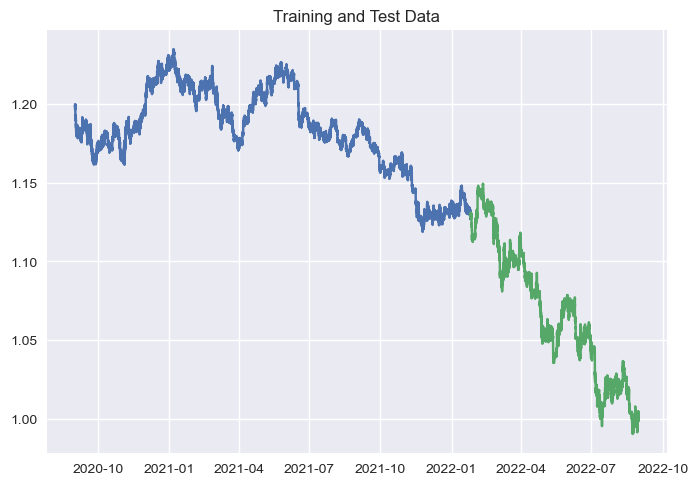

In [42]:

plt.plot(train.close)
plt.plot(test.close)
plt.title("Training and Test Data")
plt.show()

# Feature Scaling

In [43]:
train[cols]

,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:30:00,0.0,0.0,0.0,1.0,1.0,0.001834,0.001837,0.001831,0.001830,0.001819,1.200197,1.200351,1.200458,1.200514,1.200565,1.197753,1.197427,1.197126,1.196878,1.196603,-0.001693,-0.001918,-0.002035,-0.002109,-0.002318,0.000392,0.000267,0.000250,0.000175,0.000183,-0.000072,-0.000028,0.000117,0.000114,0.000108,0.000409,0.000407,0.000407,0.000408,0.000424
2020-09-01 04:35:00,1.0,0.0,0.0,0.0,1.0,0.001828,0.001834,0.001837,0.001831,0.001830,1.200007,1.200197,1.200351,1.200458,1.200514,1.198125,1.197753,1.197427,1.197126,1.196878,-0.001893,-0.001693,-0.001918,-0.002035,-0.002109,0.000183,0.000392,0.000267,0.000250,0.000175,0.000022,-0.000072,-0.000028,0.000117,0.000114,0.000410,0.000409,0.000407,0.000407,0.000408
2020-09-01 04:40:00,0.0,1.0,0.0,0.0,0.0,0.001814,0.001828,0.001834,0.001837,0.001831,1.199603,1.200007,1.200197,1.200351,1.200458,1.198691,1.198125,1.197753,1.197427,1.197126,-0.000284,-0.001893,-0.001693,-0.001918,-0.002035,0.000392,0.000183,0.000392,0.000267,0.000250,-0.000042,0.000022,-0.000072,-0.000028,0.000117,0.000414,0.000410,0.000409,0.000407,0.000407
2020-09-01 04:45:00,1.0,0.0,1.0,0.0,0.0,0.001714,0.001814,0.001828,0.001834,0.001837,1.199595,1.199603,1.200007,1.200197,1.200351,1.198688,1.198691,1.198125,1.197753,1.197427,-0.000292,-0.000284,-0.001893,-0.001693,-0.001918,0.000384,0.000392,0.000183,0.000392,0.000267,0.000003,-0.000042,0.000022,-0.000072,-0.000028,0.000199,0.000414,0.000410,0.000409,0.000407
2020-09-01 04:50:00,0.0,1.0,0.0,1.0,0.0,0.001609,0.001714,0.001814,0.001828,0.001834,1.199583,1.199595,1.199603,1.200007,1.200197,1.198675,1.198688,1.198691,1.198125,1.197753,-0.000175,-0.000292,-0.000284,-0.001893,-0.001693,0.000500,0.000384,0.000392,0.000183,0.000392,-0.000106,0.000003,-0.000042,0.000022,-0.000072,0.000200,0.000199,0.000414,0.000410,0.000409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25 15:05:00,0.0,0.0,0.0,1.0,1.0,-0.000101,-0.000142,-0.000164,-0.000185,-0.000210,1.127964,1.127982,1.127973,1.127956,1.127908,1.126692,1.126648,1.126644,1.126648,1.126666,-0.000302,-0.000585,-0.000772,-0.000922,-0.000603,0.000798,0.000514,0.000328,0.000177,0.000497,-0.000207,-0.000006,0.000109,0.000269,0.000160,0.000268,0.000277,0.000277,0.000275,0.000274
2022-01-25 15:10:00,0.0,0.0,0.0,0.0,1.0,-0.000085,-0.000101,-0.000142,-0.000164,-0.000185,1.127965,1.127964,1.127982,1.127973,1.127956,1.126686,1.126692,1.126648,1.126644,1.126648,-0.000266,-0.000302,-0.000585,-0.000772,-0.000922,0.000834,0.000798,0.000514,0.000328,0.000177,-0.000169,-0.000207,-0.000006,0.000109,0.000269,0.000261,0.000268,0.000277,0.000277,0.000275
2022-01-25 15:15:00,1.0,0.0,0.0,0.0,0.0,-0.000061,-0.000085,-0.000101,-0.000142,-0.000164,1.127977,1.127965,1.127964,1.127982,1.127973,1.126695,1.126686,1.126692,1.126648,1.126644,-0.000630,-0.000266,-0.000302,-0.000585,-0.000772,0.000470,0.000834,0.000798,0.000514,0.000328,0.000015,-0.000169,-0.000207,-0.000006,0.000109,0.000271,0.000261,0.000268,0.000277,0.000277


In [44]:
mu, std = train.mean(), train.std() # train set parameters (mu--> mean, std ---> std deviation) for standardization

In [45]:
Z_train = (train - mu) / std # standardization of train set features
Z_train =Z_train[cols]
Z_train

,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:30:00,-0.969512,-0.969493,-0.969493,1.031457,1.031437,3.625242,3.630094,3.618026,3.616583,3.593897,0.624608,0.630156,0.634023,0.636056,0.637899,0.598116,0.586283,0.575349,0.566310,0.556329,-1.588807,-1.923098,-2.096506,-2.207745,-2.517496,-0.321092,-0.492651,-0.515517,-0.618427,-0.606983,-0.575619,-0.218437,0.942454,0.920044,0.875379,1.972036,1.953167,1.954789,1.955108,2.110258
2020-09-01 04:35:00,1.031437,-0.969493,-0.969493,-0.969493,1.031437,3.612649,3.624978,3.629831,3.617763,3.616323,0.617722,0.624594,0.630141,0.634008,0.636041,0.611640,0.598102,0.586268,0.575334,0.566296,-1.885734,-1.588758,-1.923035,-2.096436,-2.207652,-0.607010,-0.321087,-0.492645,-0.515512,-0.618417,0.183341,-0.575613,-0.218442,0.942442,0.920028,1.980200,1.971990,1.953122,1.954746,1.955055
2020-09-01 04:40:00,-0.969512,1.031457,-0.969493,-0.969493,-0.969512,3.585495,3.612386,3.624715,3.629567,3.617504,0.603070,0.617707,0.624579,0.630127,0.633994,0.632188,0.611625,0.598088,0.586254,0.575320,0.506182,-1.885680,-1.588702,-1.922969,-2.096346,-0.321092,-0.607004,-0.321080,-0.492640,-0.515503,-0.330085,0.183347,-0.575617,-0.218449,0.942426,2.014962,1.980154,1.971944,1.953078,1.954693
2020-09-01 04:45:00,1.031437,-0.969493,1.031457,-0.969493,-0.969512,3.388333,3.585233,3.612124,3.624452,3.629307,0.602782,0.603055,0.617693,0.624565,0.630113,0.632070,0.632174,0.611611,0.598074,0.586240,0.493789,0.506196,-1.885617,-1.588643,-1.922884,-0.332531,-0.321087,-0.606997,-0.321076,-0.492631,0.027096,-0.330078,0.183340,-0.575622,-0.218471,0.027311,2.014915,1.980109,1.971900,1.953026
2020-09-01 04:50:00,-0.969512,1.031457,-0.969493,1.031457,-0.969512,3.183301,3.388084,3.584973,3.611862,3.624192,0.602368,0.602767,0.603041,0.617678,0.624550,0.631614,0.632056,0.632160,0.611598,0.598060,0.667306,0.493803,0.506211,-1.885552,-1.588568,-0.172368,-0.332526,-0.321080,-0.606992,-0.321067,-0.843541,0.027102,-0.330083,0.183332,-0.575646,0.038309,0.027297,2.014869,1.980065,1.971847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25 15:05:00,-0.969512,-0.969493,-0.969493,1.031457,1.031437,-0.182615,-0.262914,-0.306216,-0.348333,-0.397134,-1.993474,-1.992891,-1.993252,-1.993932,-1.995721,-1.982417,-1.984079,-1.984299,-1.984202,-1.983603,0.479262,0.057510,-0.219115,-0.442962,0.031230,0.236326,-0.153147,-0.408615,-0.615353,-0.177463,-1.657285,-0.042711,0.883287,2.165622,1.287215,0.668776,0.747146,0.747128,0.729694,0.719014
2022-01-25 15:10:00,-0.969512,-0.969493,-0.969493,-0.969493,1.031437,-0.150345,-0.182638,-0.262933,-0.306233,-0.348348,-1.993438,-1.993534,-1.992950,-1.993312,-1.993991,-1.982628,-1.982476,-1.984137,-1.984358,-1.984261,0.532000,0.479276,0.057533,-0.219089,-0.442920,0.285026,0.236331,-0.153141,-0.408611,-0.615344,-1.348743,-1.657279,-0.042717,0.883276,2.165611,0.601996,0.668752,0.747121,0.747104,0.729665
2022-01-25 15:15:00,1.031437,-0.969493,-0.969493,-0.969493,-0.969512,-0.104301,-0.150370,-0.182661,-0.262952,-0.306250,-1.992985,-1.993497,-1.993593,-1.993009,-1.993371,-1.982297,-1.982686,-1.982534,-1.984196,-1.984417,-0.008393,0.532014,0.479292,0.057553,-0.219054,-0.213988,0.285031,0.236336,-0.153137,-0.408602,0.123490,-1.348738,-1.657279,-0.042724,0.883259,0.692458,0.601973,0.668728,0.747097,0.747075


In [46]:
# standardization of test set features (with train set parameters)

Z_test = (test - mu) / std 
Z_test = Z_test[cols]


In [47]:
Z_train =Z_train[cols]
y_train = train["dir"]
y_test = test[cols]

# Saving Parameters and Dataframes

In [48]:
params = {"mu":mu, "std":std}

In [49]:
pkl.dump(params, open("datasets/params.pkl", "wb"))

In [50]:
Z_train.to_pickle("datasets/Z_train.pkl")
Z_test.to_pickle("datasets/Z_test.pkl")
y_test.to_pickle("datasets/y_test.pkl")
y_train.to_pickle("datasets/y_train.pkl")
train.to_pickle("datasets/train.pkl")
test.to_pickle("datasets/test.pkl")
pkl.dump(cols, open("datasets/cols.pkl", "wb"))
df.to_pickle("datasets/eur_usd_transformed.pkl")

In [ ]:
[
    'dir_lag_1', 'dir_lag_2', 'dir_lag_3', 'dir_lag_4', 'dir_lag_5',
    'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5',
    'bol1_lag_1', 'bol1_lag_2', 'bol1_lag_3', 'bol1_lag_4', 'bol1_lag_5',
    'bol2_lag_1', 'bol2_lag_2', 'bol2_lag_3', 'bol2_lag_4', 'bol2_lag_5',
    'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5',
    'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5',
    'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5',
    'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5'
]